# **Sarcasm Classification: Comprehensive Model Exploration (Part 2)**

**Author: Shanmugam Udhaya**

*Contact:* [@frostbitepillars](https://t.me/frostbitepillars) for any clarifications  

---

In **Part 1**, we intentionally skipped text pre-processing and performed **feature ablation** on a wide set of linguistic indicators. From that, we settled on a core set of 17 linguistic features, which we’ll now treat as our standard linguistic feature set throughout this series.

---

## **Feature Vector and Method**

For this stage, our full feature vector will consist of the following:

- **TF-IDF (Unigrams)**  
  Captures frequency-based importance of individual words.

- **GloVe 300D Word Embeddings**  
  Specifically, we use the pre-trained **GloVe 300D vectors** trained on **Wikipedia 2014 + Gigaword 5**. Each headline is represented using a **mean-pooled vector** of its tokens.

- **17 Linguistic Features**  
  Handcrafted structural, syntactic, and stylistic indicators (defined in Part 1).

---

To understand the value of each feature type, we will try different combinations of features:

- **TF-IDF + Linguistic**
- **GloVe + Linguistic**
- **TF-IDF + GloVe**
- **All Three Combined**

This helps us measure how much each modality contributes to sarcasm detection and whether simpler combinations can match more complex ones.

## **Model Exploration**

The bulk of this notebook will comprise of trying different models which are,


- Logistic Regression
- Sentence Transformer to replace GloVe embeddings
- BERT CLS to replace GloVe embeddings
  - Non Fine Tuned
  - Fine Tuned
- Feed Forward Neural Network

 - Alternative take on Logistic Regression by using a single layer of nn.Linear(input_size, 2)
  - One hidden layer
- RNN
- LSTM
 - Explore effects of using pre-trained vectors, bidirectional, number of layers, more complex projection heads, use of attention
- LSTM w/ Features
- LSTM w/ BERT (use BERT token embeddings instead of GloVe)


## **Summary of Findings**
You can find specific scores here

https://docs.google.com/document/d/1m3TwS5kWPg6si5BhshMV-hWLO3y7y6ryf6-w26ARQ2Q/edit?usp=sharing

Key findings include
- BERT embeddings, specifically extracting the CLS token can be a very powerful feature.
- Classification task is very feature driven, a Logistic Regression model can achieve close or even better results than sequential RNN/LSTM models. This is good as it gives way to possibly more insightful findings

- Going forward we will spend more time on feature development such as enhancing our embeddings or expanding our linguistic set.






## Load Data

In [ ]:
import pandas as pd
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
!gdown 1eVjlFhPvpgXmj-wH52qAzdIUyHrfs92G

Downloading...
From: https://drive.google.com/uc?id=1eVjlFhPvpgXmj-wH52qAzdIUyHrfs92G
To: /content/archive (7).zip
100% 3.46M/3.46M [00:00<00:00, 195MB/s]


In [ ]:
!unzip "archive (7).zip"

Archive:  archive (7).zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [ ]:
import pandas as pd

df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [ ]:
print(df.columns)
print(df.isnull().sum())
print(Counter(df['is_sarcastic']))
print(df.head(10))

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')
is_sarcastic    0
headline        0
article_link    0
dtype: int64
Counter({0: 14985, 1: 13634})
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   
5             0                               my white inheritance   
6             0         5 ways to file your taxes with less stress   
7             1  richard branson's global-warming donation near...   
8             1  shadow government getting too large to meet in...   
9             0                 lots of parents know this scenario   

                                        article_link  
0  https:

## Pre-Processing

### No Pre-Processing at all

In [ ]:
df['clean_headline'] = df['headline']

### With Pre-Processing

In [ ]:
def preprocess_text(text, action, stopword):
  #Lower Caps
  #text = text.lower()
  #Remove Punctuations
  #text = text.translate(str.maketrans('', '', string.punctuation))

  #https://www.geeksforgeeks.org/text-preprocessing-for-nlp-tasks/
    # text = text.lower()  # Lowercase
  #text = re.sub(r'\d+', '', text)  # Remove numbers
    #text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
  #text = re.sub(r'\W', ' ', text)  # Remove special characters
    # text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
  # Tokenize and remove stopwords
  words = word_tokenize(text)
  if stopword:
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

  #If stemming
  if action == "S":
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
  elif action == "L":
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
  return " ".join(words)

# Apply preprocessing to the text column
df['clean_headline'] = df['headline'].apply(lambda text: preprocess_text(text, "", False))

## Linguistic Features from (feature eng1)

In [ ]:
def get_pos_counts(text):
    """
    Returns a dictionary with counts of certain POS tags (NOUN, VERB, ADJ, ADV)
    """
    pos_tags = pos_tag(word_tokenize(text))
    counts = {
        'noun_count': 0,
        'verb_count': 0,
        'adj_count': 0,
        'adv_count': 0
    }
    for word, tag in pos_tags:
        if tag.startswith('NN'):
            counts['noun_count'] += 1
        elif tag.startswith('VB'):
            counts['verb_count'] += 1
        elif tag.startswith('JJ'):
            counts['adj_count'] += 1
        elif tag.startswith('RB'):
            counts['adv_count'] += 1
    return counts

def get_text_length(text):
    return len(word_tokenize(text))

import spacy
nlp = spacy.load("en_core_web_sm")

def get_ner_count(text):
    doc = nlp(text)
    return len(doc.ents)

In [ ]:
df['pos_counts'] = df['clean_headline'].apply(get_pos_counts)
df['text_length'] = df['clean_headline'].apply(get_text_length)

df['noun_count'] = df['pos_counts'].apply(lambda x: x['noun_count'])
df['verb_count'] = df['pos_counts'].apply(lambda x: x['verb_count'])
df['adj_count'] = df['pos_counts'].apply(lambda x: x['adj_count'])
df['adv_count'] = df['pos_counts'].apply(lambda x: x['adv_count'])

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.5 MB/s eta 0:00:00


In [ ]:
import textstat
df['flesch_reading_ease'] = df['clean_headline'].apply(lambda text: textstat.flesch_reading_ease(text))
df['dale_chall_score'] = df['clean_headline'].apply(lambda text: textstat.dale_chall_readability_score(text))

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.7 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['clean_headline'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

In [ ]:
def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

def count_capital_chars(text):
  count=0
  for i in text:
    if i.isupper():
      count+=1
  return count

def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

def count_unique_words(text):
    return len(set(text.split()))

def count_exclamation(text):
    return text.count("!")

df['char_count'] = df['clean_headline'].apply(count_chars)
df['capital_char_count'] = df["clean_headline"].apply(lambda x:count_capital_chars(x))
df['capital_word_count'] = df["clean_headline"].apply(lambda x:count_capital_words(x))

In [ ]:
df['stopword_count'] = df['clean_headline'].apply(lambda x: len([word for word in x.split() if word in stopwords.words('english')]))
df['word_count'] = df['clean_headline'].apply(count_words)
df['stopwords_vs_words'] = df['stopword_count']/df['word_count']

In [ ]:
def has_contrastive_conjunction(text):
    contrastive_words = {"but", "although", "yet", "however", "though"}
    return int(any(word in text.split() for word in contrastive_words))

df['contrastive_marker'] = df['clean_headline'].apply(has_contrastive_conjunction)

In [ ]:
import numpy as np
import pandas as pd
import textstat
import string
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from textblob import TextBlob
from scipy.stats import entropy

nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from scipy.stats import entropy
def calculate_entropy(text):
    words = word_tokenize(text.lower())
    freq_dist = Counter(words)
    probs = np.array(list(freq_dist.values())) / sum(freq_dist.values())
    return entropy(probs, base=2)  # Shannon Entropy

df["entropy"] = df["clean_headline"].apply(calculate_entropy)

### 2. **Lexical Diversity (Unique Words / Total Words)**
def lexical_diversity(text):
    words = word_tokenize(text.lower())
    return len(set(words)) / len(words) if len(words) > 0 else 0

df["lexical_diversity"] = df["clean_headline"].apply(lexical_diversity)

### 6. **Wrong Words (Words Not in WordNet)**
def count_wrong_words(text):
    words = word_tokenize(text.lower())
    return sum(1 for word in words if not wordnet.synsets(word))

df["wrong_word_count"] = df["clean_headline"].apply(count_wrong_words)

### 7. **Difficult Words (Hard-to-Read Words)**
df["difficult_word_count"] = df["clean_headline"].apply(textstat.difficult_words)

### 8. **Lengthy Words (Words > 2 Characters)**
df["lengthy_word_count"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) > 2))

### 9. **Two-Letter Words**
df["two_letter_words"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) == 2))

### 10. **Single-Letter Words**
df["single_letter_words"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) == 1))


In [ ]:
def detect_incongruity(text):
    tokens = word_tokenize(text)
    pos_words = 0
    neg_words = 0

    for word in tokens:
        score = analyzer.polarity_scores(word)['compound']
        if score >= 0.5:
            pos_words += 1
        elif score <= -0.5:
            neg_words += 1

    # Return 1 if both positive and negative words exist → sentiment conflict
    return int(pos_words > 0 and neg_words > 0)

# Apply to the DataFrame
df['sentiment_incongruity'] = df['clean_headline'].apply(detect_incongruity)

In [ ]:
None+1

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

## Download Glove

In [ ]:
!gdown 1HPpXpaVGK1G6W1G5wPZwF9p091qacR8i
!unzip "glove.6B.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1HPpXpaVGK1G6W1G5wPZwF9p091qacR8i
From (redirected): https://drive.google.com/uc?id=1HPpXpaVGK1G6W1G5wPZwF9p091qacR8i&confirm=t&uuid=9efc0b3b-99ac-446e-9cac-27a33941f0ca
To: /content/glove.6B.zip
100% 862M/862M [00:24<00:00, 35.7MB/s]
Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import numpy as np

def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

glove_path = "glove.6B.300d.txt"  # adjust path if needed
glove_dict = load_glove_embeddings(glove_path)

# Example: get vector for a word
print(glove_dict['amazing'])

[ 1.4999e-01  5.3597e-02  9.4669e-02  1.2415e-01 -1.0623e-01  3.2981e-01
 -3.6563e-02 -4.9109e-01  5.0600e-02 -4.8218e-01  6.9264e-01 -1.5298e-01
 -2.3069e-01  8.3252e-02  5.6969e-02 -4.4769e-01  2.7878e-01  7.0629e-02
 -2.8340e-01  4.1989e-01  3.3607e-01  3.3273e-01 -4.2430e-01  1.3433e-01
  2.4444e-01  3.6712e-01 -4.7969e-01 -3.8191e-01  1.8654e-01 -1.9120e-01
 -1.7775e-01 -2.2396e-01 -1.2442e+00 -4.2139e-01 -1.2342e+00  4.5623e-01
  1.9550e-02  7.4867e-01  4.7384e-02 -7.7133e-02 -2.6682e-01 -3.6488e-01
 -2.4977e-02 -6.0338e-02  4.1059e-02  4.3062e-01  2.4870e-01  3.4548e-02
  6.1338e-01 -4.3779e-02 -5.3384e-02  4.8766e-01 -4.4736e-02  9.4678e-02
 -2.7967e-01  7.3181e-01  5.5861e-01  8.9743e-02 -1.2702e-01 -4.8329e-02
  1.3241e-01 -2.1868e-01  4.7130e-01  2.3780e-01 -1.1905e-01  1.4091e-01
  3.4236e-02  5.8102e-02 -1.0685e-01 -1.2360e-01 -6.4432e-01 -1.2913e-02
  5.6400e-02  4.5082e-01 -1.1311e-01 -2.9463e-01 -4.4107e-02 -1.0306e-01
  5.9227e-02  8.7667e-02 -6.0326e-01 -1.5421e-01  4

In [ ]:
def sentence_to_glove_vector(sentence, glove_dict, dim=300):
    words = sentence.lower().split()
    vectors = [glove_dict[word] for word in words if word in glove_dict]
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

df['word_embedding'] = df['clean_headline'].apply(
    lambda x: sentence_to_glove_vector(x, glove_dict, dim=300)
)

## tf-idf

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

X_glove = np.vstack(df['word_embedding'].values)
X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_glove, X_ling])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_tfidf])
X_test_combined = hstack([X_test_tfidf])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


## tf-idf + Ling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

X_glove = np.vstack(df['word_embedding'].values)
X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_ling])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_tfidf, X_train_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


## Glove + tf-idf + Linguistic

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

X_glove = np.vstack(df['word_embedding'].values)
X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_glove, X_ling])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_tfidf, X_train_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


## Glove + tf-idf

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

X_glove = np.vstack(df['word_embedding'].values)
X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_glove])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_tfidf, X_train_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


## Glove + Ling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

X_glove = np.vstack(df['word_embedding'].values)
X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_glove, X_ling])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_sparse])
X_test_combined = hstack([X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


## Glove

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

X_glove = np.vstack(df['word_embedding'].values)
X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_glove])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_sparse])
X_test_combined = hstack([X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


## Linguistics

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

X_glove = np.vstack(df['word_embedding'].values)
X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_ling])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_sparse])
X_test_combined = hstack([X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


## sBERT sentence transfomer

In [ ]:
!pip install transformers
!pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

bert_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## sBERT + tf-idf + Ling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

X_bert = bert_model.encode(df['clean_headline'].tolist(), show_progress_bar=True)
print("BERT embeddings shape:", X_bert.shape)

X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_bert, X_ling])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_tfidf, X_train_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


Batches:   0%|          | 0/895 [00:00<?, ?it/s]

BERT embeddings shape: (28619, 384)
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3746
           1       0.86      0.85      0.85      3409

    accuracy                           0.86      7155
   macro avg       0.86      0.86      0.86      7155
weighted avg       0.86      0.86      0.86      7155

[[3263  483]
 [ 504 2905]]
0.8617082947059289


## sBERT + Ling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

print("BERT embeddings shape:", X_bert.shape)

X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_bert, X_ling])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_sparse])
X_test_combined = hstack([X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


## sBERT + tf-idf

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

print("BERT embeddings shape:", X_bert.shape)

X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_bert])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_tfidf, X_train_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


In [ ]:
print(X_train_combined.shape)

## sBERT Only

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

print("BERT embeddings shape:", X_bert.shape)

X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_bert])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([ X_train_sparse])
X_test_combined = hstack([X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


BERT embeddings shape: (28619, 384)
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3746
           1       0.79      0.79      0.79      3409

    accuracy                           0.80      7155
   macro avg       0.80      0.80      0.80      7155
weighted avg       0.80      0.80      0.80      7155

[[3025  721]
 [ 723 2686]]
0.7977290282930569


## Using BERT CLS

### Not Fine Tuned

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel # Use AutoModel for hidden states
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 32
RANDOM_STATE = 42

df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str)

print(f"Loading tokenizer and model: {BERT_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()
print(f"Using device: {device}")


def get_bert_cls_embeddings(texts, model, tokenizer, device, max_length, batch_size):
    """Generates [CLS] token embeddings for a list of texts."""
    all_cls_embeddings = []
    model.eval()

    print(f"Generating embeddings in batches of {batch_size}...")
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the hidden state of the [CLS] token (first token) from the last layer
        # last_hidden_state shape: (batch_size, sequence_length, hidden_size)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]

        all_cls_embeddings.append(cls_embeddings.cpu().numpy())

        if (i // batch_size + 1) % 50 == 0: # Print progress every 50 batches
             print(f"  Processed batch {i // batch_size + 1}/{len(texts) // batch_size + 1}")

    print("Finished generating embeddings.")
    # Combine embeddings from all batches
    return np.vstack(all_cls_embeddings)

print("Generating BERT [CLS] embeddings...")
X_bert = get_bert_cls_embeddings(
    df['clean_headline'].tolist(),
    bert_model,
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE
)
print("BERT [CLS] embeddings shape:", X_bert.shape) # Shape: (num_samples, 768 for bert-base)

Loading tokenizer and model: bert-base-uncased
Using device: cuda
Generating BERT [CLS] embeddings...
Generating embeddings in batches of 32...
  Processed batch 50/895
  Processed batch 100/895
  Processed batch 150/895
  Processed batch 200/895
  Processed batch 250/895
  Processed batch 300/895
  Processed batch 350/895
  Processed batch 400/895
  Processed batch 450/895
  Processed batch 500/895
  Processed batch 550/895
  Processed batch 600/895
  Processed batch 650/895
  Processed batch 700/895
  Processed batch 750/895
  Processed batch 800/895
  Processed batch 850/895
Finished generating embeddings.
BERT [CLS] embeddings shape: (28619, 768)


### BERT CLS + Ling + tf-idf

In [ ]:
# 2. Linguistic Features
print("Extracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']
X_ling = df[ling_feature_names].values
print("Linguistic features shape:", X_ling.shape)

# 3. Combine BERT [CLS] + Linguistic Features (Dense)
print("Combining BERT [CLS] and linguistic features...")
X_gling = np.hstack([X_bert, X_ling])
print("Combined BERT+Ling shape:", X_gling.shape)
y = df['is_sarcastic'].values

# --- Train/Test Split ---
print("Splitting data into train/test sets...")
# Split the combined dense features and labels, keep track of original indices
X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42 # Explicit test_size
)
print(f"Train features shape: {X_train_gling.shape}, Test features shape: {X_test_gling.shape}")

# --- Feature Scaling ---
print("Scaling combined BERT+Ling features...")
# Scale the combined BERT+Ling features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

# Convert scaled features to sparse format (optional, but hstack prefers it)
X_train_sparse_scaled = csr_matrix(X_train_scaled)
X_test_sparse_scaled = csr_matrix(X_test_scaled)
print("Scaled features shape (sparse):", X_train_sparse_scaled.shape)

# --- TF-IDF Features ---
print("Generating TF-IDF features...")
tfidf = TfidfVectorizer() # Optional: limit TF-IDF features

# Fit TF-IDF on the training text data using the train indices
X_train_tfidf = tfidf.fit_transform(df.loc[idx_train, 'clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer and test indices
X_test_tfidf = tfidf.transform(df.loc[idx_test, 'clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("Combining TF-IDF and Scaled (BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\nTraining Logistic Regression model...")
# Use a solver suitable for potentially large sparse data like liblinear or saga
lr = LogisticRegression(class_weight='balanced',max_iter=10000, random_state=42)
lr.fit(X_train_combined, Y_train)

print("\nEvaluating Logistic Regression model...")
y_pred = lr.predict(X_test_combined)

print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions in a batch/split
print(classification_report(Y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, y_pred, labels=lr.classes_)
print(cm)

print(f"\nMacro F1 Score: {f1_score(Y_test, y_pred, average='macro', zero_division=0):.4f}")

print("\n--- Script Finished ---")

Extracting linguistic features...
Linguistic features shape: (28619, 17)
Combining BERT [CLS] and linguistic features...
Combined BERT+Ling shape: (28619, 785)
Splitting data into train/test sets...
Train features shape: (21464, 785), Test features shape: (7155, 785)
Scaling combined BERT+Ling features...
Scaled features shape (sparse): (21464, 785)
Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)
Combining TF-IDF and Scaled (BERT+Ling) features...
Final Combined Train shape: (21464, 23968)
Final Combined Test shape: (7155, 23968)

Training Logistic Regression model...

Evaluating Logistic Regression model...

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3746
           1       0.88      0.88      0.88      3409

    accuracy                           0.89      7155
   macro avg       0.89      0.89      0.89      7155
weighted avg       0.89      0.89     

### BERT CLS only

In [ ]:
# 2. Linguistic Features
print("Extracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']
X_ling = df[ling_feature_names].values
print("Linguistic features shape:", X_ling.shape)

# 3. Combine BERT [CLS] + Linguistic Features (Dense)
print("Combining BERT [CLS] and linguistic features...")
X_gling = np.hstack([X_bert])
print("Combined BERT+Ling shape:", X_gling.shape)
y = df['is_sarcastic'].values

# --- Train/Test Split ---
print("Splitting data into train/test sets...")
# Split the combined dense features and labels, keep track of original indices
X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42 # Explicit test_size
)
print(f"Train features shape: {X_train_gling.shape}, Test features shape: {X_test_gling.shape}")

# --- Feature Scaling ---
print("Scaling combined BERT+Ling features...")
# Scale the combined BERT+Ling features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

# Convert scaled features to sparse format (optional, but hstack prefers it)
X_train_sparse_scaled = csr_matrix(X_train_scaled)
X_test_sparse_scaled = csr_matrix(X_test_scaled)
print("Scaled features shape (sparse):", X_train_sparse_scaled.shape)

# --- TF-IDF Features ---
print("Generating TF-IDF features...")
tfidf = TfidfVectorizer() # Optional: limit TF-IDF features

# Fit TF-IDF on the training text data using the train indices
X_train_tfidf = tfidf.fit_transform(df.loc[idx_train, 'clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer and test indices
X_test_tfidf = tfidf.transform(df.loc[idx_test, 'clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("Combining TF-IDF and Scaled (BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([ X_train_sparse_scaled])
X_test_combined = hstack([X_test_sparse_scaled])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\nTraining Logistic Regression model...")
# Use a solver suitable for potentially large sparse data like liblinear or saga
lr = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
lr.fit(X_train_combined, Y_train)

print("\nEvaluating Logistic Regression model...")
y_pred = lr.predict(X_test_combined)

print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions in a batch/split
print(classification_report(Y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, y_pred, labels=lr.classes_)
print(cm)

print(f"\nMacro F1 Score: {f1_score(Y_test, y_pred, average='macro', zero_division=0):.4f}")

print("\n--- Script Finished ---")

Extracting linguistic features...
Linguistic features shape: (28619, 17)
Combining BERT [CLS] and linguistic features...
Combined BERT+Ling shape: (28619, 768)
Splitting data into train/test sets...
Train features shape: (21464, 768), Test features shape: (7155, 768)
Scaling combined BERT+Ling features...
Scaled features shape (sparse): (21464, 768)
Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)
Combining TF-IDF and Scaled (BERT+Ling) features...
Final Combined Train shape: (21464, 768)
Final Combined Test shape: (7155, 768)

Training Logistic Regression model...

Evaluating Logistic Regression model...

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3746
           1       0.85      0.85      0.85      3409

    accuracy                           0.86      7155
   macro avg       0.86      0.86      0.86      7155
weighted avg       0.86      0.86      0.8

### BERT CLS + Ling

In [ ]:
# 2. Linguistic Features
print("Extracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']
X_ling = df[ling_feature_names].values
print("Linguistic features shape:", X_ling.shape)

# 3. Combine BERT [CLS] + Linguistic Features (Dense)
print("Combining BERT [CLS] and linguistic features...")
X_gling = np.hstack([X_bert, X_ling])
print("Combined BERT+Ling shape:", X_gling.shape)
y = df['is_sarcastic'].values

# --- Train/Test Split ---
print("Splitting data into train/test sets...")
# Split the combined dense features and labels, keep track of original indices
X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42 # Explicit test_size
)
print(f"Train features shape: {X_train_gling.shape}, Test features shape: {X_test_gling.shape}")

# --- Feature Scaling ---
print("Scaling combined BERT+Ling features...")
# Scale the combined BERT+Ling features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

# Convert scaled features to sparse format (optional, but hstack prefers it)
X_train_sparse_scaled = csr_matrix(X_train_scaled)
X_test_sparse_scaled = csr_matrix(X_test_scaled)
print("Scaled features shape (sparse):", X_train_sparse_scaled.shape)

# --- TF-IDF Features ---
print("Generating TF-IDF features...")
tfidf = TfidfVectorizer() # Optional: limit TF-IDF features

# Fit TF-IDF on the training text data using the train indices
X_train_tfidf = tfidf.fit_transform(df.loc[idx_train, 'clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer and test indices
X_test_tfidf = tfidf.transform(df.loc[idx_test, 'clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("Combining TF-IDF and Scaled (BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([ X_train_sparse_scaled])
X_test_combined = hstack([ X_test_sparse_scaled])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\nTraining Logistic Regression model...")
# Use a solver suitable for potentially large sparse data like liblinear or saga
lr = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
lr.fit(X_train_combined, Y_train)

print("\nEvaluating Logistic Regression model...")
y_pred = lr.predict(X_test_combined)

print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions in a batch/split
print(classification_report(Y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, y_pred, labels=lr.classes_)
print(cm)

print(f"\nMacro F1 Score: {f1_score(Y_test, y_pred, average='macro', zero_division=0):.4f}")

print("\n--- Script Finished ---")

Extracting linguistic features...
Linguistic features shape: (28619, 17)
Combining BERT [CLS] and linguistic features...
Combined BERT+Ling shape: (28619, 785)
Splitting data into train/test sets...
Train features shape: (21464, 785), Test features shape: (7155, 785)
Scaling combined BERT+Ling features...
Scaled features shape (sparse): (21464, 785)
Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)
Combining TF-IDF and Scaled (BERT+Ling) features...
Final Combined Train shape: (21464, 785)
Final Combined Test shape: (7155, 785)

Training Logistic Regression model...

Evaluating Logistic Regression model...

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3746
           1       0.86      0.86      0.86      3409

    accuracy                           0.87      7155
   macro avg       0.87      0.87      0.87      7155
weighted avg       0.87      0.87      0.8

### BERT CLS + tf-idf

In [ ]:
# 2. Linguistic Features
print("Extracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']
X_ling = df[ling_feature_names].values
print("Linguistic features shape:", X_ling.shape)

# 3. Combine BERT [CLS] + Linguistic Features (Dense)
print("Combining BERT [CLS] and linguistic features...")
X_gling = np.hstack([X_bert])
print("Combined BERT+Ling shape:", X_gling.shape)
y = df['is_sarcastic'].values

# --- Train/Test Split ---
print("Splitting data into train/test sets...")
# Split the combined dense features and labels, keep track of original indices
X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42 # Explicit test_size
)
print(f"Train features shape: {X_train_gling.shape}, Test features shape: {X_test_gling.shape}")

# --- Feature Scaling ---
print("Scaling combined BERT+Ling features...")
# Scale the combined BERT+Ling features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

# Convert scaled features to sparse format (optional, but hstack prefers it)
X_train_sparse_scaled = csr_matrix(X_train_scaled)
X_test_sparse_scaled = csr_matrix(X_test_scaled)
print("Scaled features shape (sparse):", X_train_sparse_scaled.shape)

# --- TF-IDF Features ---
print("Generating TF-IDF features...")
tfidf = TfidfVectorizer() # Optional: limit TF-IDF features

# Fit TF-IDF on the training text data using the train indices
X_train_tfidf = tfidf.fit_transform(df.loc[idx_train, 'clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer and test indices
X_test_tfidf = tfidf.transform(df.loc[idx_test, 'clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("Combining TF-IDF and Scaled (BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\nTraining Logistic Regression model...")
# Use a solver suitable for potentially large sparse data like liblinear or saga
lr = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
lr.fit(X_train_combined, Y_train)

print("\nEvaluating Logistic Regression model...")
y_pred = lr.predict(X_test_combined)

print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions in a batch/split
print(classification_report(Y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, y_pred, labels=lr.classes_)
print(cm)

print(f"\nMacro F1 Score: {f1_score(Y_test, y_pred, average='macro', zero_division=0):.4f}")

print("\n--- Script Finished ---")

Extracting linguistic features...
Linguistic features shape: (28619, 17)
Combining BERT [CLS] and linguistic features...
Combined BERT+Ling shape: (28619, 768)
Splitting data into train/test sets...
Train features shape: (21464, 768), Test features shape: (7155, 768)
Scaling combined BERT+Ling features...
Scaled features shape (sparse): (21464, 768)
Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)
Combining TF-IDF and Scaled (BERT+Ling) features...
Final Combined Train shape: (21464, 23951)
Final Combined Test shape: (7155, 23951)

Training Logistic Regression model...

Evaluating Logistic Regression model...

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3746
           1       0.87      0.88      0.87      3409

    accuracy                           0.88      7155
   macro avg       0.88      0.88      0.88      7155
weighted avg       0.88      0.88     

### Fine Tuned

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from datasets import Dataset
import evaluate
import os

BASE_BERT_MODEL_NAME = 'bert-base-uncased'
FINETUNED_MODEL_DIR = "./bert_sarcasm_finetuned"
MAX_LENGTH = 128
BATCH_SIZE_EMBEDDING = 32
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Fine-tuning hyperparameters
NUM_TRAIN_EPOCHS = 2 # Adjust as needed (2-4 is common)
LEARNING_RATE = 2e-5
TRAIN_BATCH_SIZE_FT = 16 # Fine-tuning train batch size
EVAL_BATCH_SIZE_FT = 32 # Fine-tuning evaluation batch size
WEIGHT_DECAY = 0.01

df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Initial Data Split ---
print("Splitting data into train/test sets...")
train_df, test_df = train_test_split(
    df,
    stratify=df['is_sarcastic'],
    random_state=42
)
# Store indices for later use
idx_train = train_df.index
idx_test = test_df.index
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# --- 2. Fine-Tune BERT ---
print("\n--- Step 2: Fine-Tuning BERT ---")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_BERT_MODEL_NAME)

# Prepare datasets for Hugging Face Trainer
train_dataset_hf = Dataset.from_pandas(train_df[['clean_headline', 'is_sarcastic']])
test_dataset_hf = Dataset.from_pandas(test_df[['clean_headline', 'is_sarcastic']])

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['clean_headline'],
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH
    )

# Apply tokenization
print("Tokenizing datasets for fine-tuning...")
train_dataset_hf = train_dataset_hf.map(tokenize_function, batched=True)
test_dataset_hf = test_dataset_hf.map(tokenize_function, batched=True)

# Rename label column and set format
train_dataset_hf = train_dataset_hf.rename_column("is_sarcastic", "labels")
test_dataset_hf = test_dataset_hf.rename_column("is_sarcastic", "labels")
columns_to_keep_hf = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
train_dataset_hf.set_format(type='torch', columns=columns_to_keep_hf)
test_dataset_hf.set_format(type='torch', columns=columns_to_keep_hf)

# Load model for sequence classification
print(f"Loading base model '{BASE_BERT_MODEL_NAME}' for fine-tuning...")
model_for_finetuning = AutoModelForSequenceClassification.from_pretrained(
    BASE_BERT_MODEL_NAME,
    num_labels=2 # Binary classification (sarcastic/not sarcastic)
)
# Move model to device BEFORE defining Trainer if possible
model_for_finetuning.to(device)

# Define evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Detach tensors and move to CPU if necessary before numpy conversion
    if isinstance(labels, torch.Tensor): labels = labels.cpu().numpy()
    if isinstance(logits, torch.Tensor): logits = logits.cpu().numpy()

    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1": f1}

# Define Training Arguments
training_args = TrainingArguments(
    output_dir=FINETUNED_MODEL_DIR,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE_FT,
    per_device_eval_batch_size=EVAL_BATCH_SIZE_FT,
    weight_decay=WEIGHT_DECAY,
    evaluation_strategy="epoch", # Evaluate at the end of each epoch
    save_strategy="epoch",       # Save checkpoint at the end of each epoch
    logging_strategy="epoch",    # Log metrics at the end of each epoch
    load_best_model_at_end=True, # Load the best checkpoint based on metric_for_best_model
    metric_for_best_model="f1",  # Use F1 score to determine the best model
    greater_is_better=True,      # Higher F1 is better
    report_to="none",            # Disable wandb/tensorboard reporting if not needed
    # no_cuda= (device.type == 'cpu') # Explicitly tell trainer if no cuda
)

# Create Trainer instance
trainer = Trainer(
    model=model_for_finetuning, # Model already on device
    args=training_args,
    train_dataset=train_dataset_hf,
    eval_dataset=test_dataset_hf, # Using test set for evaluation during fine-tuning
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Start fine-tuning
print("Starting fine-tuning process...")
trainer.train()
print("Fine-tuning finished.")

# Explicitly save the best model found by the Trainer
print(f"Saving the best fine-tuned model to {FINETUNED_MODEL_DIR}...")
trainer.save_model(FINETUNED_MODEL_DIR)
tokenizer.save_pretrained(FINETUNED_MODEL_DIR) # Save tokenizer with the model

print("Evaluating the best fine-tuned model...")
eval_results = trainer.evaluate(test_dataset_hf)
print("Fine-tuning Evaluation Results:", eval_results)


# --- 3. Load Fine-Tuned Encoder and Extract Embeddings ---
print("\n--- Step 3: Extracting [CLS] Embeddings from Fine-Tuned Model ---")

# Load the fine-tuned model's base encoder part
print(f"Loading fine-tuned encoder from {FINETUNED_MODEL_DIR}...")
try:
    # Load the full classification model first
    fine_tuned_classifier = AutoModelForSequenceClassification.from_pretrained(FINETUNED_MODEL_DIR)
    # Access the base model (encoder)
    if hasattr(fine_tuned_classifier, 'bert'):
        bert_encoder_finetuned = fine_tuned_classifier.bert
    elif hasattr(fine_tuned_classifier, 'roberta'):
         bert_encoder_finetuned = fine_tuned_classifier.roberta
    # Add checks for other architectures if needed
    else:
         # Fallback: try loading AutoModel directly (might work if saved that way)
         print("Could not find standard base model attribute, trying AutoModel directly...")
         bert_encoder_finetuned = AutoModel.from_pretrained(FINETUNED_MODEL_DIR)

    bert_encoder_finetuned.to(device) # Ensure it's on the correct device
    bert_encoder_finetuned.eval()     # Set to evaluation mode
    # Reload tokenizer just to be sure it matches the saved model
    tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL_DIR)
    print("Fine-tuned encoder loaded successfully.")

except Exception as e:
    print(f"Error loading fine-tuned encoder: {e}")
    print(f"Falling back to base '{BASE_BERT_MODEL_NAME}'. Embeddings will NOT be from fine-tuned model.")
    # Load base model as fallback
    tokenizer = AutoTokenizer.from_pretrained(BASE_BERT_MODEL_NAME)
    bert_encoder_finetuned = AutoModel.from_pretrained(BASE_BERT_MODEL_NAME)
    bert_encoder_finetuned.to(device)
    bert_encoder_finetuned.eval()

# Function to Get BERT [CLS] Embeddings (same as before)
def get_bert_cls_embeddings(texts, model, tokenizer, device, max_length, batch_size):
    """Generates [CLS] token embeddings for a list of texts."""
    all_cls_embeddings = []
    model.eval() # Ensure model is in eval mode
    print(f"Generating embeddings in batches of {batch_size}...")
    num_batches = (len(texts) + batch_size - 1) // batch_size
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        all_cls_embeddings.append(cls_embeddings.cpu().numpy())
        current_batch_num = (i // batch_size) + 1
        if current_batch_num % 50 == 0 or current_batch_num == num_batches:
             print(f"  Processed batch {current_batch_num}/{num_batches}")
    print("Finished generating embeddings.")
    return np.vstack(all_cls_embeddings)

# Generate embeddings using the FINE-TUNED encoder for the ENTIRE dataset
print("Generating BERT [CLS] embeddings using the fine-tuned model...")
X_bert_finetuned = get_bert_cls_embeddings(
    df['clean_headline'].tolist(), # Use full dataset text
    bert_encoder_finetuned,        # Use the fine-tuned encoder
    tokenizer,                     # Use the corresponding tokenizer
    device,
    MAX_LENGTH,
    BATCH_SIZE_EMBEDDING
)
print("Fine-tuned BERT [CLS] embeddings shape:", X_bert_finetuned.shape)

Using device: cuda
Splitting data into train/test sets...
Train size: 21464, Test size: 7155

--- Step 2: Fine-Tuning BERT ---
Tokenizing datasets for fine-tuning...


Map:   0%|          | 0/21464 [00:00<?, ? examples/s]

Map:   0%|          | 0/7155 [00:00<?, ? examples/s]

Loading base model 'bert-base-uncased' for fine-tuning...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-38-105714e504a4>:136: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting fine-tuning process...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.275800,0.201322,0.925786,0.925530
2,0.122900,0.306013,0.922572,0.922068


Fine-tuning finished.
Saving the best fine-tuned model to ./bert_sarcasm_finetuned...
Evaluating the best fine-tuned model...


Fine-tuning Evaluation Results: {'eval_loss': 0.20132198929786682, 'eval_accuracy': 0.9257861635220126, 'eval_f1': 0.9255295596374782, 'eval_runtime': 49.069, 'eval_samples_per_second': 145.815, 'eval_steps_per_second': 4.565, 'epoch': 2.0}

--- Step 3: Extracting [CLS] Embeddings from Fine-Tuned Model ---
Loading fine-tuned encoder from ./bert_sarcasm_finetuned...
Fine-tuned encoder loaded successfully.
Generating BERT [CLS] embeddings using the fine-tuned model...
Generating embeddings in batches of 32...
  Processed batch 50/895
  Processed batch 100/895
  Processed batch 150/895
  Processed batch 200/895
  Processed batch 250/895
  Processed batch 300/895
  Processed batch 350/895
  Processed batch 400/895
  Processed batch 450/895
  Processed batch 500/895
  Processed batch 550/895
  Processed batch 600/895
  Processed batch 650/895
  Processed batch 700/895
  Processed batch 750/895
  Processed batch 800/895
  Processed batch 850/895
  Processed batch 895/895
Finished generating 

### Fine Tuned BERT CLS + Ling + tf-idf

In [ ]:
# --- 4. Prepare Features for Logistic Regression ---
print("\n--- Step 4: Preparing Features for Logistic Regression ---")

# Linguistic Features (from full dataset)
print("Extracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']
X_ling = df[ling_feature_names].values
print("Linguistic features shape:", X_ling.shape)

# Combine Fine-tuned BERT [CLS] + Linguistic Features
print("Combining fine-tuned BERT [CLS] and linguistic features...")
X_gling_finetuned = np.hstack([X_bert_finetuned, X_ling])
print("Combined BERT+Ling shape:", X_gling_finetuned.shape)
y = df['is_sarcastic'].values

# Split combined features using the indices from the initial split
X_train_gling = X_gling_finetuned[idx_train]
X_test_gling = X_gling_finetuned[idx_test]
Y_train = y[idx_train]
Y_test = y[idx_test]
print(f"Train combined dense features shape: {X_train_gling.shape}")
print(f"Test combined dense features shape: {X_test_gling.shape}")

# Feature Scaling (on combined BERT+Ling)
print("Scaling combined BERT+Ling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)
X_train_sparse_scaled = csr_matrix(X_train_scaled)
X_test_sparse_scaled = csr_matrix(X_test_scaled)
print("Scaled features shape (sparse):", X_train_sparse_scaled.shape)

# TF-IDF Features (using original train/test split text)
print("Generating TF-IDF features...")
tfidf = TfidfVectorizer() # Optional limit
# Fit on train text identified by idx_train
X_train_tfidf = tfidf.fit_transform(df.loc[idx_train, 'clean_headline'])
# Transform test text identified by idx_test
X_test_tfidf = tfidf.transform(df.loc[idx_test, 'clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# Final Feature Combination
print("Combining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...")
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)


# --- 5. Logistic Regression Model ---
print("\n--- Step 5: Logistic Regression Training and Evaluation ---")

print("Training Logistic Regression model...")
lr = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
lr.fit(X_train_combined, Y_train)

print("\nEvaluating Logistic Regression model...")
y_pred_lr = lr.predict(X_test_combined)

print("\nClassification Report:")
print(classification_report(Y_test, y_pred_lr, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, y_pred_lr, labels=lr.classes_)
print(cm)

print(f"\nMacro F1 Score: {f1_score(Y_test, y_pred_lr, average='macro', zero_division=0):.4f}")

print("\n--- Script Finished ---")


--- Step 4: Preparing Features for Logistic Regression ---
Extracting linguistic features...
Linguistic features shape: (28619, 17)
Combining fine-tuned BERT [CLS] and linguistic features...
Combined BERT+Ling shape: (28619, 785)
Train combined dense features shape: (21464, 785)
Test combined dense features shape: (7155, 785)
Scaling combined BERT+Ling features...
Scaled features shape (sparse): (21464, 785)
Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)
Combining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...
Final Combined Train shape: (21464, 23968)
Final Combined Test shape: (7155, 23968)

--- Step 5: Logistic Regression Training and Evaluation ---
Training Logistic Regression model...

Evaluating Logistic Regression model...

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3746
           1       0.93      0.92      0.92      3409

    accuracy  

### Fine Tuned BERT CLS Only

In [ ]:
# --- 4. Prepare Features for Logistic Regression ---
print("\n--- Step 4: Preparing Features for Logistic Regression ---")

# Linguistic Features (from full dataset)
print("Extracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']
X_ling = df[ling_feature_names].values
print("Linguistic features shape:", X_ling.shape)

# Combine Fine-tuned BERT [CLS] + Linguistic Features
print("Combining fine-tuned BERT [CLS] and linguistic features...")
X_gling_finetuned = np.hstack([X_bert_finetuned, X_ling])
print("Combined BERT+Ling shape:", X_gling_finetuned.shape)
y = df['is_sarcastic'].values

# Split combined features using the indices from the initial split
X_train_gling = X_gling_finetuned[idx_train]
X_test_gling = X_gling_finetuned[idx_test]
Y_train = y[idx_train]
Y_test = y[idx_test]
print(f"Train combined dense features shape: {X_train_gling.shape}")
print(f"Test combined dense features shape: {X_test_gling.shape}")

# Feature Scaling (on combined BERT+Ling)
print("Scaling combined BERT+Ling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)
X_train_sparse_scaled = csr_matrix(X_train_scaled)
X_test_sparse_scaled = csr_matrix(X_test_scaled)
print("Scaled features shape (sparse):", X_train_sparse_scaled.shape)

# TF-IDF Features (using original train/test split text)
print("Generating TF-IDF features...")
tfidf = TfidfVectorizer() # Optional limit
# Fit on train text identified by idx_train
X_train_tfidf = tfidf.fit_transform(df.loc[idx_train, 'clean_headline'])
# Transform test text identified by idx_test
X_test_tfidf = tfidf.transform(df.loc[idx_test, 'clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# Final Feature Combination
print("Combining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...")
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)


# --- 5. Logistic Regression Model ---
print("\n--- Step 5: Logistic Regression Training and Evaluation ---")

print("Training Logistic Regression model...")
lr = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
lr.fit(X_train_combined, Y_train)

print("\nEvaluating Logistic Regression model...")
y_pred_lr = lr.predict(X_test_combined)

print("\nClassification Report:")
print(classification_report(Y_test, y_pred_lr, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, y_pred_lr, labels=lr.classes_)
print(cm)

print(f"\nMacro F1 Score: {f1_score(Y_test, y_pred_lr, average='macro', zero_division=0):.4f}")

print("\n--- Script Finished ---")


--- Step 4: Preparing Features for Logistic Regression ---
Extracting linguistic features...
Linguistic features shape: (28619, 17)
Combining fine-tuned BERT [CLS] and linguistic features...
Combined BERT+Ling shape: (28619, 785)
Train combined dense features shape: (21464, 785)
Test combined dense features shape: (7155, 785)
Scaling combined BERT+Ling features...
Scaled features shape (sparse): (21464, 785)
Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)
Combining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...
Final Combined Train shape: (21464, 23968)
Final Combined Test shape: (7155, 23968)

--- Step 5: Logistic Regression Training and Evaluation ---
Training Logistic Regression model...

Evaluating Logistic Regression model...

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3746
           1       0.93      0.92      0.92      3409

    accuracy  

### sBERT again

--- Generating Placeholder Data (Replace with your actual data loading) ---
Placeholder DataFrame shape: (28619, 29)
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  \
0  https://www.theonion.com/thirtysomething-scien...   
1  https://www.huffingtonpost.com/entry/donna-edw...   
2  https://www.huffingtonpost.com/entry/eat-your-...   
3  https://local.theonion.com/inclement-weather-p...   
4  https://www.theonion.com/mother-comes-pretty-c...   

                                      clean_headline  \
0  thirtysomething scientists unveil doomsday clo...   
1  dem rep. t

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence-BERT model loaded.
Generating SBERT embeddings for all headlines...


Batches:   0%|          | 0/448 [00:00<?, ?it/s]

Finished generating embeddings in 14.88 seconds.
SBERT embeddings shape: (28619, 384)

--- Step 3: Preparing Features for Logistic Regression ---
Extracting linguistic features...
Linguistic features shape: (28619, 17)
Combining SBERT embeddings and linguistic features...
Combined SBERT+Ling shape: (28619, 401)
Train combined dense features shape: (21464, 401)
Test combined dense features shape: (7155, 401)
Scaling combined SBERT+Ling features...
Scaled features shape (sparse): (21464, 401)
Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)
Combining TF-IDF and Scaled (SBERT+Ling) features...
Final Combined Train shape: (21464, 23584)
Final Combined Test shape: (7155, 23584)

--- Step 4: Logistic Regression Training and Evaluation ---
Training Logistic Regression model...

Evaluating Logistic Regression model...

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3

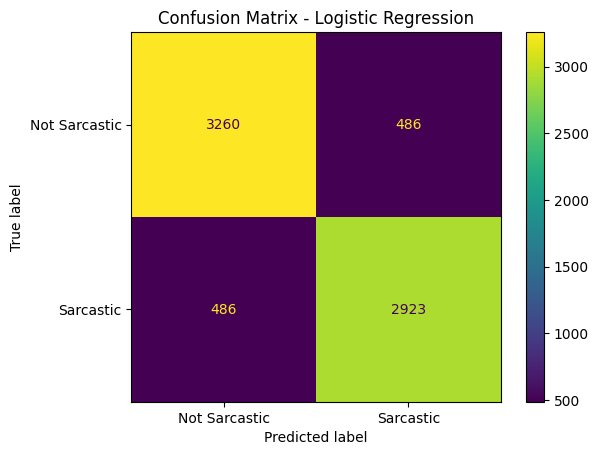


Macro F1 Score (calculated using 'evaluate'): 0.8638
Macro F1 Score (calculated using 'sklearn'): 0.8638

--- Script Finished ---


In [ ]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer # Import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import evaluate # Hugging Face evaluation library (can keep for metric functions if desired)
import time # To time embedding generation

# --- Configuration ---
SBERT_MODEL_NAME = 'all-MiniLM-L6-v2' # Popular Sentence-BERT model
BATCH_SIZE_EMBEDDING = 64
RANDOM_STATE = 42
TEST_SIZE = 0.25

df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Initial Data Split ---
print("\n--- Step 1: Splitting data into train/test sets ---")
train_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE, # Use TEST_SIZE variable
    stratify=df['is_sarcastic'],
    random_state=RANDOM_STATE # Use RANDOM_STATE variable
)
# Store indices for later use
idx_train = train_df.index
idx_test = test_df.index
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# --- 2. Generate Sentence-BERT Embeddings (Contrastive Learning based) ---
print("\n--- Step 2: Generating Sentence-BERT Embeddings ---")

# Load a pre-trained Sentence Transformer model
print(f"Loading Sentence-BERT model: '{SBERT_MODEL_NAME}'...")
sbert_model = SentenceTransformer(SBERT_MODEL_NAME, device=device)
print("Sentence-BERT model loaded.")

# Generate embeddings for the ENTIRE dataset's headlines
print("Generating SBERT embeddings for all headlines...")
start_time = time.time()
# Use model.encode() which handles tokenization and pooling internally
X_sbert = sbert_model.encode(
    df['clean_headline'].tolist(),
    batch_size=BATCH_SIZE_EMBEDDING,
    show_progress_bar=True,
    convert_to_numpy=True # Get numpy array directly
)
end_time = time.time()
print(f"Finished generating embeddings in {end_time - start_time:.2f} seconds.")
print("SBERT embeddings shape:", X_sbert.shape)

# --- 3. Prepare Features for Logistic Regression ---
print("\n--- Step 3: Preparing Features for Logistic Regression ---")

# Linguistic Features (from full dataset)
print("Extracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']
# Ensure all ling feature columns exist in the DataFrame
missing_ling_cols = [col for col in ling_feature_names if col not in df.columns]
if missing_ling_cols:
    raise ValueError(f"Missing linguistic feature columns in DataFrame: {missing_ling_cols}")

X_ling = df[ling_feature_names].values
print("Linguistic features shape:", X_ling.shape)

# Combine SBERT Embeddings + Linguistic Features
print("Combining SBERT embeddings and linguistic features...")
# Make sure shapes are compatible for hstack: (n_samples, n_features_sbert) and (n_samples, n_features_ling)
if X_sbert.shape[0] != X_ling.shape[0]:
     raise ValueError(f"Mismatch in number of samples between SBERT ({X_sbert.shape[0]}) and Ling ({X_ling.shape[0]}) features.")
X_gling_sbert = np.hstack([X_sbert, X_ling])
print("Combined SBERT+Ling shape:", X_gling_sbert.shape)
y = df['is_sarcastic'].values

# Split combined features using the indices from the initial split
X_train_gling = X_gling_sbert[idx_train]
X_test_gling = X_gling_sbert[idx_test]
Y_train = y[idx_train]
Y_test = y[idx_test]
print(f"Train combined dense features shape: {X_train_gling.shape}")
print(f"Test combined dense features shape: {X_test_gling.shape}")

# Feature Scaling (on combined SBERT+Ling)
print("Scaling combined SBERT+Ling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)
X_train_sparse_scaled = csr_matrix(X_train_scaled) # Convert to sparse for hstack
X_test_sparse_scaled = csr_matrix(X_test_scaled)   # Convert to sparse for hstack
print("Scaled features shape (sparse):", X_train_sparse_scaled.shape)

# TF-IDF Features (using original train/test split text)
print("Generating TF-IDF features...")
tfidf = TfidfVectorizer() # Optional: limit max TF-IDF features
# Fit on train text identified by idx_train
X_train_tfidf = tfidf.fit_transform(df.loc[idx_train, 'clean_headline'])
# Transform test text identified by idx_test
X_test_tfidf = tfidf.transform(df.loc[idx_test, 'clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# Final Feature Combination
print("Combining TF-IDF and Scaled (SBERT+Ling) features...")
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled]).tocsr() # Ensure CSR format
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled]).tocsr()   # Ensure CSR format
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)


# --- 4. Logistic Regression Model ---
print("\n--- Step 4: Logistic Regression Training and Evaluation ---")

print("Training Logistic Regression model...")
lr = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=RANDOM_STATE) # Changed solver for potential speedup with sparse data
# Note: 'saga' solver also handles sparse data well and supports L1/L2/ElasticNet, but might be slower than liblinear for this scale.
# 'sag' typically works better on dense data after scaling.
# 'lbfgs' might struggle with the high dimensionality after TF-IDF.
lr.fit(X_train_combined, Y_train)

print("\nEvaluating Logistic Regression model...")
y_pred_lr = lr.predict(X_test_combined)
y_prob_lr = lr.predict_proba(X_test_combined)[:, 1] # Get probabilities for class 1

print("\nClassification Report:")
print(classification_report(Y_test, y_pred_lr, zero_division=0))

print("\nConfusion Matrix:")
# Use display labels for clarity if desired
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    cm = confusion_matrix(Y_test, y_pred_lr, labels=lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
    disp.plot()
    plt.title("Confusion Matrix - Logistic Regression")
    plt.show()
except ImportError:
    print("Install matplotlib and sklearn for confusion matrix visualization: pip install matplotlib")
    # Fallback to text display
    cm = confusion_matrix(Y_test, y_pred_lr, labels=lr.classes_)
    print(cm)


# Using evaluate library for F1 score
f1_metric = evaluate.load("f1")
macro_f1 = f1_metric.compute(predictions=y_pred_lr, references=Y_test, average="macro")["f1"]
print(f"\nMacro F1 Score (calculated using 'evaluate'): {macro_f1:.4f}")
# Or using sklearn directly
print(f"Macro F1 Score (calculated using 'sklearn'): {f1_score(Y_test, y_pred_lr, average='macro', zero_division=0):.4f}")


print("\n--- Script Finished ---")

## Simple NN

### Setup X and Y vector here

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

X_glove = np.vstack(df['word_embedding'].values)
X_ling = df[['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
             'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
             'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
             'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']].values

X_gling = np.hstack([X_glove, X_ling])
y = df['is_sarcastic'].values

X_train_gling, X_test_gling, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_gling, y, df.index, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gling)
X_test_scaled = scaler.transform(X_test_gling)

X_train_sparse = csr_matrix(X_train_scaled)
X_test_sparse = csr_matrix(X_test_scaled)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf_all = tfidf.fit_transform(df['clean_headline'])

X_train_tfidf = X_tfidf_all[idx_train]
X_test_tfidf = X_tfidf_all[idx_test]

# Combine
X_train_combined = hstack([X_train_tfidf, X_train_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_sparse])

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train_combined, Y_train)

y_pred = lr.predict(X_test_combined)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))


In [ ]:
print(X_train_combined.shape)

### Continue training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train_combined.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_combined.toarray(), dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### No hidden layer

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_dim, 2)
        )

    def forward(self, x):
        x = self.fc1(x)
        return x


### One hidden layer

In [ ]:
#Uncomment as needed to use it

# class SimpleNN(nn.Module):
#     def __init__(self, input_dim):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, 2)
#         )

#     def forward(self, x):
#         x = self.fc1(x)
#         return x


In [ ]:
print(X_train_combined.shape[1])
model = SimpleNN(X_train_combined.shape[1])
model.to(device)
print(model(torch.randn(32, X_train_combined.shape[1]).to(device)).shape)

23968
torch.Size([32, 2])


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
None+1

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

## RNN

In [ ]:
None+1

In [ ]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
max_seq_length = 30
vocab_size = 25000

X_train, X_test, Y_train, Y_test = train_test_split(df['clean_headline'], df['is_sarcastic'], random_state=42, stratify=df['is_sarcastic'])

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_seq_length, padding="post")
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_seq_length, padding="post")
print(X_train_seq.shape)

In [ ]:
#vocab_size = len(tokenizer.word_index)+1
embedding_dim = 300
hidden_dim = 32
batch_size = 32

In [ ]:
print("Tokenizer vocabulary size:", len(tokenizer.word_index))


In [ ]:
train_tensor = torch.tensor(X_train_seq, dtype=torch.long)
test_tensor = torch.tensor(X_test_seq, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, torch.tensor(Y_train.values, dtype=torch.long))
test_dataset = TensorDataset(test_tensor, torch.tensor(Y_test.values, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in glove_dict:
        embedding_matrix[i] = glove_dict[word]

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, pre_trained_embed=True):
        super(RNN, self).__init__()
        self.embedding = None

        if pre_trained_embed:
          # not pretrained -> nn.Embedding(vocab_size, embedding_dim)
          self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        else:
          self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x) #(batch, seq_len, hidden)
        x = self.fc(x[:, -1, :]) # (batch, hidden) -> (batch, 2)
        return x

In [ ]:
model = RNN(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True).to(device)

In [ ]:
best_model = RNN(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
None+1

## LSTM

In [ ]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [ ]:
vocab_size = 25000
embedding_dim = 300
hidden_dim = 64
max_seq_length = 30
batch_size = 32

X_train, X_test, Y_train, Y_test = train_test_split(df['clean_headline'], df['is_sarcastic'], random_state=42, stratify=df['is_sarcastic'])

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_seq_length, padding="post")
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_seq_length, padding="post")
print(X_train_seq.shape)

In [ ]:
train_tensor = torch.tensor(X_train_seq, dtype=torch.long)
test_tensor = torch.tensor(X_test_seq, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, torch.tensor(Y_train.values, dtype=torch.long))
test_dataset = TensorDataset(test_tensor, torch.tensor(Y_test.values, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in glove_dict:
        embedding_matrix[i] = glove_dict[word]

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, pre_trained_embed=True, bidirectional=False, freeze=False, num_layers=1):
        super(LSTM, self).__init__()

        if pre_trained_embed:
            self.embedding = nn.Embedding.from_pretrained(
                torch.tensor(embedding_matrix, dtype=torch.float),
                freeze=freeze
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, output_dim)
        # self.fc = nn.Sequential(
        #     nn.Linear(lstm_output_dim, 64),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(64, 2)
        # )

    def forward(self, x):
        embed = self.embedding(x)
        output, (hidden, cell) = self.lstm(embed)

        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        out = self.fc(hidden)
        return out


In [ ]:
class LSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2,
                 pre_trained_embed=True, bidirectional=False, freeze=False, num_layers=1):
        super(LSTMWithAttention, self).__init__()

        if pre_trained_embed:
            self.embedding = nn.Embedding.from_pretrained(
                torch.tensor(embedding_matrix, dtype=torch.float),
                freeze=freeze
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Attention layer
        self.attention = nn.Linear(hidden_dim * self.num_directions, 1)

        # Final FC layer
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

    def forward(self, x):
        embed = self.embedding(x)                     # (batch, seq_len, embed_dim)
        output, (hidden, cell) = self.lstm(embed)     # output: (batch, seq_len, hidden*dir)

        # Attention mechanism
        attn_weights = torch.softmax(self.attention(output), dim=1)  # (batch, seq_len, 1)
        context = torch.sum(attn_weights * output, dim=1)            # (batch, hidden*dir)

        out = self.fc(context)  # classification head
        return out


In [ ]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, pre_trained_embed=True, bidirectional=False, freeze=False, num_layers=1):
        super(GRU, self).__init__()

        if pre_trained_embed:
            self.embedding = nn.Embedding.from_pretrained(
                torch.tensor(embedding_matrix, dtype=torch.float),
                freeze=freeze
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        gru_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(gru_output_dim, output_dim)

        # Optional deeper FC version:
        # self.fc = nn.Sequential(
        #     nn.Linear(gru_output_dim, 1024),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(1024, output_dim)
        # )

    def forward(self, x):
        embed = self.embedding(x)
        output, hidden = self.gru(embed)

        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        out = self.fc(hidden)
        return out


In [ ]:
model = LSTM(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True, bidirectional=True, freeze=False,num_layers=1).to(device)
#best_model = LSTM(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True, bidirectional=False, freeze=False).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
None+1

## LSTM with Features

### With Glove

In [ ]:
handcrafted_features = [
    'text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count',
    'dale_chall_score', 'sentiment_score', 'char_count', 'capital_char_count',
    'capital_word_count', 'stopword_count', 'stopwords_vs_words', 'contrastive_marker',
    'entropy', 'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count'
]

# Tokenizer
vocab_size = 25000
max_seq_length = 30
embedding_dim = 300
hidden_dim = 64
batch_size = 32

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_headline'])
X_seq = pad_sequences(tokenizer.texts_to_sequences(df['clean_headline']), maxlen=max_seq_length, padding="post")

X_glove = np.vstack(df['word_embedding'].values)
X_ling = df[handcrafted_features].values
X_combined = np.hstack([X_glove, X_ling])

y = df['is_sarcastic'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_seq, X_combined, y, stratify=y, random_state=42
)

### With SentenceTransformer

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# This assumes df['clean_headline'] exists
X_bert = bert_model.encode(df['clean_headline'].tolist(), show_progress_bar=True)
print("BERT embeddings shape:", X_bert.shape)

In [ ]:
handcrafted_features = [
    'text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count',
    'dale_chall_score', 'sentiment_score', 'char_count', 'capital_char_count',
    'capital_word_count', 'stopword_count', 'stopwords_vs_words', 'contrastive_marker',
    'entropy', 'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count'
]

# Tokenizer
vocab_size = 25000
max_seq_length = 30
embedding_dim = 300
hidden_dim = 64
batch_size = 32

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_headline'])
X_seq = pad_sequences(tokenizer.texts_to_sequences(df['clean_headline']), maxlen=max_seq_length, padding="post")

X_bert_stacked = np.vstack(X_bert)
X_ling = df[handcrafted_features].values
X_combined = np.hstack([X_bert_stacked, X_ling])

y = df['is_sarcastic'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_seq, X_combined, y, stratify=y, random_state=42
)

### Rest

In [ ]:
scaler = StandardScaler()
X_feat_train_scaled = scaler.fit_transform(X_feat_train)
X_feat_test_scaled = scaler.transform(X_feat_test)

train_dataset = TensorDataset(
    torch.tensor(X_seq_train, dtype=torch.long),
    torch.tensor(X_feat_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_seq_test, dtype=torch.long),
    torch.tensor(X_feat_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
print(X_feat_test.shape)

for i in train_loader:
  print(i[0].shape, i[1].shape, i[2].shape)
  break

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in glove_dict:
        embedding_matrix[i] = glove_dict[word]

In [ ]:
class LSTMWithFeatures(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, extra_feat_dim,
                 output_dim=2, pre_trained_embed=True, freeze=False, bidirectional=False, num_layers=1):
        super(LSTMWithFeatures, self).__init__()

        if pre_trained_embed:
            self.embedding = nn.Embedding.from_pretrained(
                torch.tensor(embedding_matrix, dtype=torch.float),
                freeze=freeze
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        #self.fc = nn.Linear(lstm_output_dim + extra_feat_dim, output_dim)
        self.fc = nn.Sequential(
            nn.Linear(lstm_output_dim + extra_feat_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_dim)
        )

        print(f"LSTM input dimension: {embedding_dim}")
        print(f"LSTM hidden dimension: {hidden_dim}")
        print(f"LSTM output dimension: {lstm_output_dim}")
        print(f"extra_feat_dim: {extra_feat_dim}")
        print(f"fc input dimension: {lstm_output_dim + extra_feat_dim}")

    def forward(self, x_seq, x_extra):
        embed = self.embedding(x_seq)
        output, (hidden, _) = self.lstm(embed)

        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        combined = torch.cat((hidden, x_extra), dim=1)
        return self.fc(combined)

In [ ]:
model = LSTMWithFeatures(
    vocab_size=len(tokenizer.word_index)+1,
    embedding_dim=300,
    hidden_dim=64,
    extra_feat_dim=X_feat_train_scaled.shape[1],
    pre_trained_embed=True,
    freeze=False,
    bidirectional=True,
    num_layers=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
patience = 8

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for seq, feat, labels in loader:
            seq, feat, labels = seq.to(device), feat.to(device), labels.to(device)
            outputs = model(seq, feat)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Test Macro F1: {f1:.4f}")
    return f1

def train(model, train_loader, test_loader, epochs=20):
    best_f1 = 0
    no_improve = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        y_true, y_pred = [], []
        for seq, feat, labels in train_loader:
            seq, feat, labels = seq.to(device), feat.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(seq, feat)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            total_loss += loss.item()

        train_f1 = f1_score(y_true, y_pred, average='macro')
        print(f"\nEpoch {epoch+1}")
        print(f"Train Loss: {total_loss:.4f}")
        print(f"Train F1: {train_f1:.4f}")

        val_f1 = evaluate(model, test_loader)
        scheduler.step(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            no_improve = 0
            print("Saving best model...")
            torch.save(model.state_dict(), "lstm_with_features.pt")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered.")
                break

train(model, train_loader, test_loader)

In [ ]:
#tmp = SimpleNN(X_train_combined.shape[1])
#tmp = RNN(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True).to(device)
tmp = LSTMWithFeatures(
    vocab_size=len(tokenizer.word_index)+1,
    embedding_dim=300,
    hidden_dim=64,
    extra_feat_dim=X_feat_train_scaled.shape[1],
    pre_trained_embed=True,
    freeze=False,
    bidirectional=True,
    num_layers=1
).to(device)
#tmp = LSTMWithAttention(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True, bidirectional=False, freeze=False,num_layers=1).to(device)
#tmp = GRU(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True, bidirectional=True, freeze=False,num_layers=1).to(device)
tmp.load_state_dict(torch.load("lstm_with_features.pt"))
evaluate(tmp, test_loader)

In [ ]:
None+1

## BERT

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Split
X_train, X_test, Y_train, Y_test = train_test_split(df['clean_headline'], df['is_sarcastic'], random_state=42, stratify=df['is_sarcastic'])

In [ ]:
def tokenize(texts, max_len=30):
    encoding = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=max_len
    )
    return encoding['input_ids'], encoding['attention_mask']

X_train_ids, X_train_mask = tokenize(X_train)
X_test_ids, X_test_mask = tokenize(X_test)

# Dataset
train_dataset = TensorDataset(X_train_ids, X_train_mask, torch.tensor(Y_train.values))
test_dataset = TensorDataset(X_test_ids, X_test_mask, torch.tensor(Y_test.values))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, freeze_bert=True):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        return self.fc(cls_output)

# Init
model = BERTClassifier(freeze_bert=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
patience = 5

In [ ]:
def evaluate(model, test_loader, verbose, device):
    model.eval()
    y_pred, y_true = [], []

    with torch.no_grad():
        for ids, masks, labels in test_loader:
            ids, masks, labels = ids.to(device), masks.to(device), labels.to(device)
            outputs = model(ids, masks)
            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro Test F1: {macro_f1:.4f}")
    return macro_f1

# Train Function
def train(model, train_loader, device, epochs=10):
    best_f1 = 0
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        y_pred, y_true = [], []
        running_loss = 0.0

        for ids, masks, labels in train_loader:
            ids, masks, labels = ids.to(device), masks.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(ids, masks)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            running_loss += loss.item()

        train_f1 = f1_score(y_true, y_pred, average='macro')
        print(f"\nEpoch {epoch+1}")
        print(f"Train Loss: {running_loss:.4f}")
        print(f"Train F1: {train_f1:.4f}")

        test_f1 = evaluate(model, test_loader, True, device)
        scheduler.step(test_f1)

        if test_f1 > best_f1:
            best_f1 = test_f1
            no_improve = 0
            print("New best model! Saving...")
            torch.save(model.state_dict(), "best_bert_model.pt")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered.")
                break

train(model, train_loader, device)

## LSTM w/ BERT

### Load BERT

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import AutoTokenizer, AutoModel # Use AutoModel for base encoder
import random
import os

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased' # Or other BERT model
MAX_SEQ_LENGTH = 64  # Adjust based on your data and BERT's limits
BATCH_SIZE = 32
LSTM_HIDDEN_DIM = 128 # You can tune this
NUM_LSTM_LAYERS = 1
BIDIRECTIONAL_LSTM = True
LEARNING_RATE = 1e-4 # Learning rate for the LSTM/FC layers
EPOCHS = 5 # Number of epochs to train LSTM/FC layers
RANDOM_STATE = 42

# --- Seed Setting ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if use multi-GPU
        # Ensure deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(RANDOM_STATE)

# --- Load Your Data ---
# Replace this with your actual data loading
# Ensure you have 'clean_headline' and 'is_sarcastic' columns
# Example Dummy Data:
df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str)
# --- End Data Loading ---


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Load Pre-trained BERT Model and Tokenizer ---
print(f"Loading BERT model: {BERT_MODEL_NAME}")
tokenizer_bert = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME)

# --- FREEZE BERT parameters ---
# We treat BERT purely as a feature extractor here
for param in bert_model.parameters():
    param.requires_grad = False

bert_model.to(device) # Move BERT to the correct device
bert_model.eval() # Set BERT to evaluation mode
bert_hidden_size = bert_model.config.hidden_size
print(f"BERT hidden size: {bert_hidden_size}")

# --- 2. Data Splitting and Tokenization (using BERT Tokenizer) ---
X_train, X_test, Y_train, Y_test = train_test_split(
    df['clean_headline'].tolist(), # Pass list of strings
    df['is_sarcastic'].values,     # Pass numpy array
    random_state=42,
    stratify=df['is_sarcastic']
)

print("Tokenizing data with BERT tokenizer...")
# Tokenize function for BERT
def tokenize_bert(texts, tokenizer, max_len):
    return tokenizer(
        texts,
        add_special_tokens=True, # Add [CLS] and [SEP]
        max_length=max_len,
        padding='max_length',    # Pad to max_len
        truncation=True,         # Truncate longer sequences
        return_attention_mask=True, # Return attention mask
        return_tensors='pt'      # Return PyTorch tensors
    )

# Apply tokenization
train_encodings = tokenize_bert(X_train, tokenizer_bert, MAX_SEQ_LENGTH)
test_encodings = tokenize_bert(X_test, tokenizer_bert, MAX_SEQ_LENGTH)



### Train

In [ ]:
# --- 3. Create PyTorch Datasets and DataLoaders ---
class SarcasmDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        # Detach is important if encodings were created with grad tracking
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SarcasmDataset(train_encodings, Y_train)
test_dataset = SarcasmDataset(test_encodings, Y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

In [ ]:
# --- 4. Define the LSTM Model using BERT Embeddings ---
class BertLSTMClassifier(nn.Module):
    def __init__(self, bert_model, lstm_hidden_dim, output_dim=2, num_layers=1, bidirectional=True, dropout_prob=0.3):
        super(BertLSTMClassifier, self).__init__()

        self.bert = bert_model
        self.bert_hidden_size = bert_model.config.hidden_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.bidirectional = bidirectional

        # LSTM layer - input size is BERT's hidden dimension
        self.lstm = nn.LSTM(
            input_size=self.bert_hidden_size,
            hidden_size=lstm_hidden_dim,
            num_layers=num_layers,
            batch_first=True, # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_prob if num_layers > 1 else 0 # Add dropout between LSTM layers if num_layers > 1
        )

        # Calculate the input dimension for the fully connected layer
        lstm_output_dim = lstm_hidden_dim * 2 if bidirectional else lstm_hidden_dim

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Dropout(dropout_prob), # Apply dropout before the final layer
            nn.Linear(lstm_output_dim, output_dim)
            # Optional: Add more layers if needed
            # nn.ReLU(),
            # nn.Linear(some_intermediate_dim, output_dim)
        )

    def forward(self, input_ids, attention_mask):
        # Pass data through BERT (ensure BERT is frozen and in eval mode if desired)
        # No gradient calculation needed for BERT forward pass here
        with torch.no_grad():
            bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            # bert_embeddings shape: (batch_size, seq_length, bert_hidden_size)
            bert_embeddings = bert_outputs.last_hidden_state

        # Pass BERT embeddings through LSTM
        # lstm_out shape: (batch_size, seq_length, num_directions * hidden_dim)
        # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
        lstm_out, (hidden, cell) = self.lstm(bert_embeddings)

        # Extract the final hidden state (or combine directions for bidirectional)
        if self.bidirectional:
            # Concatenate the final hidden states from forward (hidden[-2]) and backward (hidden[-1]) directions
            final_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
            # Alternative: Use the last output token's hidden state from LSTM `lstm_out[:, -1, :]`
            # final_hidden_state = lstm_out[:, -1, :] # Shape: (batch_size, num_directions * hidden_dim)
        else:
            # Get the hidden state of the last layer
            final_hidden_state = hidden[-1,:,:]
            # Alternative: Use the last output token's hidden state from LSTM `lstm_out[:, -1, :]`
            # final_hidden_state = lstm_out[:, -1, :] # Shape: (batch_size, hidden_dim)

        # Pass the final hidden state through the fully connected layer
        logits = self.fc(final_hidden_state) # Shape: (batch_size, output_dim)
        return logits

# --- 5. Initialize Model, Loss Function, Optimizer ---
model = BertLSTMClassifier(
    bert_model=bert_model, # Pass the frozen BERT model
    lstm_hidden_dim=LSTM_HIDDEN_DIM,
    num_layers=NUM_LSTM_LAYERS,
    bidirectional=BIDIRECTIONAL_LSTM
)
model.to(device)

criterion = nn.CrossEntropyLoss()
# Only optimize parameters of the LSTM and FC layer (BERT is frozen)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# --- 6. Training Loop ---
print("\n--- Starting Training ---")
model.train() # Set model to training mode (affects dropout, etc.)
# Note: BERT part remains in eval mode internally due to the earlier bert_model.eval() call if you want it fully frozen.
# If you intended BERT to use its dropout during this phase (less common when frozen), you'd need more careful handling.

for epoch in range(EPOCHS):
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for i, batch in enumerate(train_loader):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Calculate loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Calculate accuracy (optional, for monitoring)
        _, predicted = torch.max(outputs, dim=1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if (i + 1) % 50 == 0: # Print progress every 50 batches
            print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_epoch_loss = epoch_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:")
    print(f"  Average Training Loss: {avg_epoch_loss:.4f}")
    print(f"  Training Accuracy: {epoch_accuracy:.4f}")

# --- 7. Evaluation Loop ---
print("\n--- Evaluating on Test Set ---")
model.eval() # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad(): # Disable gradient calculations
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs, dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 8. Report Results ---
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))

macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
weighted_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"\nMacro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

print("\n--- Script Finished ---")

### Fine-Tuned BERT

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup # Added scheduler
import random
import os

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased' # Or other BERT model
MAX_SEQ_LENGTH = 64  # Adjust based on your data and BERT's limits
BATCH_SIZE = 16 # Smaller batch size might be needed due to memory usage of fine-tuning BERT
LSTM_HIDDEN_DIM = 128 # You can tune this
NUM_LSTM_LAYERS = 1
BIDIRECTIONAL_LSTM = True
# *** CRITICAL: Use a small learning rate for fine-tuning ***
LEARNING_RATE = 2e-5 # Typical fine-tuning learning rate for BERT
EPOCHS = 3 # Fine-tuning often requires fewer epochs (2-4 is common)
RANDOM_STATE = 42
GRADIENT_CLIP_VALUE = 1.0 # Optional gradient clipping

# --- Seed Setting ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if use multi-GPU
        # Ensure deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(RANDOM_STATE)

df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str)
# --- End Data Loading ---


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Load Pre-trained BERT Model and Tokenizer ---
print(f"Loading BERT model: {BERT_MODEL_NAME} for fine-tuning")
tokenizer_bert = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
# Load the base model, gradients will be enabled by default
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME)

# *** BERT parameters are NOT frozen this time ***
# for param in bert_model.parameters():
#     param.requires_grad = True # This is the default, no need to set explicitly

bert_hidden_size = bert_model.config.hidden_size
print(f"BERT hidden size: {bert_hidden_size}")

# --- 2. Data Splitting and Tokenization (using BERT Tokenizer) ---
X_train, X_test, Y_train, Y_test = train_test_split(
    df['clean_headline'].tolist(), # Pass list of strings
    df['is_sarcastic'].values,     # Pass numpy array
    test_size=0.25,                # Using 25% for test
    random_state=RANDOM_STATE,
    stratify=df['is_sarcastic']
)

print("Tokenizing data with BERT tokenizer...")
# Tokenize function for BERT (same as before)
def tokenize_bert(texts, tokenizer, max_len):
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

train_encodings = tokenize_bert(X_train, tokenizer_bert, MAX_SEQ_LENGTH)
test_encodings = tokenize_bert(X_test, tokenizer_bert, MAX_SEQ_LENGTH)

# --- 3. Create PyTorch Datasets and DataLoaders ---
# SarcasmDataset class remains the same as the previous example
class SarcasmDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Ensure tensors are returned correctly
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SarcasmDataset(train_encodings, Y_train)
test_dataset = SarcasmDataset(test_encodings, Y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

# --- 4. Define the Fine-Tuning Model (BERT + LSTM + Classifier) ---
class BertLSTMFineTuneClassifier(nn.Module):
    def __init__(self, bert_model, lstm_hidden_dim, output_dim=2, num_layers=1, bidirectional=True, dropout_prob=0.3):
        super(BertLSTMFineTuneClassifier, self).__init__()

        self.bert = bert_model # The BERT model (not frozen)
        self.bert_hidden_size = bert_model.config.hidden_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=self.bert_hidden_size,
            hidden_size=lstm_hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_prob if num_layers > 1 else 0
        )

        lstm_output_dim = lstm_hidden_dim * 2 if bidirectional else lstm_hidden_dim

        self.fc = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(lstm_output_dim, output_dim)
        )

    def forward(self, input_ids, attention_mask):
        # Pass data through BERT - gradients WILL flow back this time
        # NO torch.no_grad() here
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = bert_outputs.last_hidden_state # (batch, seq_len, bert_hidden)

        # Pass BERT embeddings through LSTM
        lstm_out, (hidden, cell) = self.lstm(bert_embeddings) # lstm_out: (batch, seq_len, lstm_hidden * num_dir)

        # Extract final hidden state
        if self.bidirectional:
            # Concatenate final forward and backward hidden states
            final_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            final_hidden_state = hidden[-1,:,:]

        # Classifier head
        logits = self.fc(final_hidden_state)
        return logits

# --- 5. Initialize Model, Loss Function, Optimizer, Scheduler ---
model = BertLSTMFineTuneClassifier(
    bert_model=bert_model, # Pass the BERT model instance
    lstm_hidden_dim=LSTM_HIDDEN_DIM,
    num_layers=NUM_LSTM_LAYERS,
    bidirectional=BIDIRECTIONAL_LSTM
)
model.to(device)

criterion = nn.CrossEntropyLoss()

# Optimizer: AdamW is recommended for Transformers. Apply to ALL model parameters.
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8) # Added epsilon

# Scheduler: Linear warmup and decay (optional but common)
num_training_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * num_training_steps) # 10% warmup is common
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# --- 6. Training Loop ---
print("\n--- Starting Fine-Tuning Training ---")

for epoch in range(EPOCHS):
    model.train() # Set model to training mode
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for i, batch in enumerate(train_loader):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Calculate loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, dim=1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Backward pass
        loss.backward()

        # Gradient Clipping (optional but recommended for fine-tuning)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VALUE)

        # Optimize and update learning rate
        optimizer.step()
        scheduler.step() # Update learning rate scheduler

        if (i + 1) % 20 == 0: # Print progress more frequently if needed
            print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.2e}")

    avg_epoch_loss = epoch_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:")
    print(f"  Average Training Loss: {avg_epoch_loss:.4f}")
    print(f"  Training Accuracy: {epoch_accuracy:.4f}")

# --- 7. Evaluation Loop ---
print("\n--- Evaluating on Test Set ---")
model.eval() # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad(): # Disable gradient calculations for evaluation
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs, dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 8. Report Results ---
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))

macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
weighted_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"\nMacro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# --- Optional: Save the fine-tuned model ---
# output_dir = "./bert_lstm_finetuned_model"
# os.makedirs(output_dir, exist_ok=True)
# print(f"\nSaving model to {output_dir}")
# # Save the entire model (including LSTM/FC layers)
# torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
# # Save the tokenizer
# tokenizer_bert.save_pretrained(output_dir)
# # You might also want to save the model configuration if needed
# # model.bert.config.save_pretrained(output_dir) # Saves BERT config

print("\n--- Script Finished ---")

Using device: cuda
Loading BERT model: bert-base-uncased for fine-tuning
BERT hidden size: 768
Tokenizing data with BERT tokenizer...
Train batches: 1342, Test batches: 448

--- Starting Fine-Tuning Training ---
Epoch [1/3], Batch [20/1342], Loss: 0.6749, LR: 9.95e-07
Epoch [1/3], Batch [40/1342], Loss: 0.6604, LR: 1.99e-06
Epoch [1/3], Batch [60/1342], Loss: 0.6800, LR: 2.99e-06
Epoch [1/3], Batch [80/1342], Loss: 0.6763, LR: 3.98e-06
Epoch [1/3], Batch [100/1342], Loss: 0.6480, LR: 4.98e-06
Epoch [1/3], Batch [120/1342], Loss: 0.5820, LR: 5.97e-06
Epoch [1/3], Batch [140/1342], Loss: 0.5224, LR: 6.97e-06
Epoch [1/3], Batch [160/1342], Loss: 0.4185, LR: 7.96e-06
Epoch [1/3], Batch [180/1342], Loss: 0.5503, LR: 8.96e-06
Epoch [1/3], Batch [200/1342], Loss: 0.2826, LR: 9.95e-06
Epoch [1/3], Batch [220/1342], Loss: 0.5241, LR: 1.09e-05
Epoch [1/3], Batch [240/1342], Loss: 0.5004, LR: 1.19e-05
Epoch [1/3], Batch [260/1342], Loss: 0.4941, LR: 1.29e-05
Epoch [1/3], Batch [280/1342], Loss: 0

## Eval/Train

In [ ]:
def evaluate(model, test_loader, verbose, device):
  with torch.no_grad():
    model.to(device)
    model.eval()
    y_pred = []
    y = []
    for input, output in test_loader:
      input = input.to(device)
      output = output.to(device)
      preds = torch.argmax(model(input), dim=1)
      y_pred.extend(preds.cpu().numpy())
      y.extend(output.cpu().numpy())
    if verbose:
      pass
      # print(classification_report(y, y_pred))
      # print(confusion_matrix(y, y_pred))
    macro_f1_score = f1_score(y, y_pred, average='macro')
    print(f"Macro Test F1: {macro_f1_score:.4f}")
    return macro_f1_score

evaluate(model, test_loader, True, device)




Macro Test F1: 0.5493


0.5492632629560703

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
patience = 8

def train(model, train_loader, device, epochs=100):
    model.to(device)
    best_test_f1 = 0
    curr = 0
    for i in range(epochs):
        model.train()
        y = []
        y_p = []
        running_loss = 0

        for input, output in train_loader:
            input = input.to(device)
            output = output.to(device)

            y_pred = model(input)
            y_pred_labels = torch.argmax(y_pred, dim=1)

            y_p.extend(y_pred_labels.cpu().numpy())
            y.extend(output.cpu().numpy())

            optimizer.zero_grad()
            loss = loss_fn(y_pred, output)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        macro_train_f1 = f1_score(y, y_p, average='macro')
        print(f"\nEpoch {i+1}/{epochs}")
        print(f"Train Loss: {running_loss:.4f}")
        print(f"Macro Training F1: {macro_train_f1:.4f}")

        # Evaluate on test set
        macro_test_f1 = evaluate(model, test_loader, True, device)
        scheduler.step(macro_test_f1)

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr:.6f}")

        if macro_test_f1 > best_test_f1:
          curr = 0
          best_test_f1 = macro_test_f1
          print("New best model! Saving...")
          torch.save(model.state_dict(), "best_model.pt")
        else:
          curr += 1
          if curr >= patience:
            print("Early Stopping..")
            break


train(model, train_loader, device)







Epoch 1/100
Train Loss: 61.0082
Macro Training F1: 0.9700
Macro Test F1: 0.9264
Current Learning Rate: 0.001000
New best model! Saving...

Epoch 2/100
Train Loss: 53.7361
Macro Training F1: 0.9726
Macro Test F1: 0.9272
Current Learning Rate: 0.001000
New best model! Saving...

Epoch 3/100
Train Loss: 49.9957
Macro Training F1: 0.9749
Macro Test F1: 0.9283
Current Learning Rate: 0.001000
New best model! Saving...

Epoch 4/100
Train Loss: 47.3907
Macro Training F1: 0.9765
Macro Test F1: 0.9269
Current Learning Rate: 0.001000

Epoch 5/100
Train Loss: 44.5494
Macro Training F1: 0.9774
Macro Test F1: 0.9278
Current Learning Rate: 0.001000

Epoch 6/100
Train Loss: 41.6076
Macro Training F1: 0.9780
Macro Test F1: 0.9263
Current Learning Rate: 0.001000

Epoch 7/100
Train Loss: 39.7610
Macro Training F1: 0.9792
Macro Test F1: 0.9276
Current Learning Rate: 0.000500

Epoch 8/100
Train Loss: 35.0683
Macro Training F1: 0.9827
Macro Test F1: 0.9275
Current Learning Rate: 0.000500

Epoch 9/100
Train

In [ ]:
#tmp = SimpleNN(X_train_combined.shape[1])
#tmp = RNN(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True).to(device)
tmp = LSTM(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True, bidirectional=True, freeze=False,num_layers=1).to(device)
#tmp = LSTMWithAttention(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True, bidirectional=False, freeze=False,num_layers=1).to(device)
#tmp = GRU(vocab_size, embedding_dim, hidden_dim=hidden_dim, pre_trained_embed=True, bidirectional=True, freeze=False,num_layers=1).to(device)
tmp.load_state_dict(torch.load("best_model.pt"))
evaluate(tmp, test_loader, True, device)

RuntimeError: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "embedding.weight", "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0", "lstm.weight_ih_l0_reverse", "lstm.weight_hh_l0_reverse", "lstm.bias_ih_l0_reverse", "lstm.bias_hh_l0_reverse", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fc1.0.weight", "fc1.0.bias". 